# Image Compression using Autoencoders with BPSK

This code is provided as supplementary material of the lecture Machine Learning and Optimization in Communications (MLOC).<br>

This code illustrates
* joint compression and error protection of images by auto-encoders
* generation of BPSK symbols using stochastic quantizers
* transmission over a binary symmetric channel (BSC)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import numpy as np
from matplotlib import pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("We are using the following device for learning:",device)

We are using the following device for learning: cpu


### Illustration of a straight-through estimator

In [46]:
def quantizer(x):
    return torch.sign(x)

x = torch.tensor([-6,-4,-3,-2,0,1,2,3,4,5], dtype=torch.float, requires_grad=True, device=device)
q = quantizer(x)
y = torch.mean(2*q)

# calculate gradient of y
y.backward()


# print input vector
print('x:', x)
print('y:', y)
# print gradient, we can see that it is zero everywhere, as the quantizer is killing the gradient
print('Gradient w.r.t x', x.grad)

x: tensor([-6., -4., -3., -2.,  0.,  1.,  2.,  3.,  4.,  5.], requires_grad=True)
y: tensor(0.2000, grad_fn=<MeanBackward0>)
Gradient w.r.t x tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


In [47]:
# quantizer without killing gradient
# the detach function detaches this part of function from the graph that is used to calculate the gradient
# The gradient is hence only computed with respect to x
qp = x + (quantizer(x) - x).detach()
yp = torch.mean(2*qp)

# compute gradient
# reset the gradient of x, needs to be done as pytorch accumulates the gradients
x.grad.zero_()
# compute gradient
yp.backward()

# print input vector
print('x\':', x)
print('y\':', yp)
# print gradient
print('Gradient w.r.t x\'', x.grad)

x': tensor([-6., -4., -3., -2.,  0.,  1.,  2.,  3.,  4.,  5.], requires_grad=True)
y': tensor(0.2000, grad_fn=<MeanBackward0>)
Gradient w.r.t x' tensor([0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000,
        0.2000])


### Import and load MNIST dataset (Preprocessing)
Dataloader are powerful instruments, which help you to prepare your data. E.g. you can shuffle your data, transform data (standardize/normalize), divide it into batches, ...  For more information see https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader <br>

In our case, we just use the dataloader to download the Dataset and preprocess the data on our own.

In [2]:
batch_size_train = 60000      # Samples per Training Batch
batch_size_test = 10000     # just create one large test dataset (MNIST test dataset has 10.000 Samples)

# Get Training and Test Dataset with a Dataloader
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./files/', train=True, download=True,
  transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor()])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./files/', train=False, download=True,
  transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor()])),
  batch_size=batch_size_test, shuffle=True)

# We are only interessted in the data and not in the targets
for idx, (data, targets) in enumerate(train_loader):
    x_train = data[:,0,:,:]

for idx, (data, targets) in enumerate(test_loader):
    x_test = data[:,0,:,:]

image_size = x_train.shape[1]
x_test_flat = torch.reshape(x_test, (x_test.shape[0], image_size*image_size))

Plot 8 random images

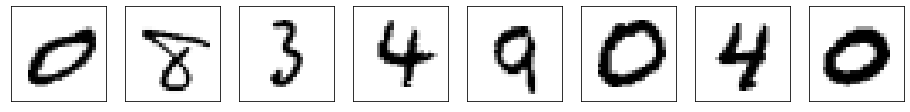

In [3]:
plt.figure(figsize=(16,2))
for k in range(8):
    plt.subplot(1,8,k+1)
    plt.imshow(x_train[np.random.randint(x_train.shape[0])], interpolation='nearest', cmap='binary')
    plt.xticks(())
    plt.yticks(())

### Specify Autoencoder
As explained in the lecture, we are using Stochstic Quantization. This means for the training process (*def forward*), we employ stochastic quantization in forward path but during back-propagation, we consider the quantization device as being
non-existent (*.detach()*). While validating and testing, use deterministic quantization (*def test*) <br>


*Note: .detach() removes the tensor from the computation graph*

In [4]:
# target compression rate
bit_per_image = 24

# BSC error probability
Pe = 0.05

hidden_encoder_1 = 500
hidden_encoder_2 = 250
hidden_encoder_3 = 100
hidden_encoder = [hidden_encoder_1, hidden_encoder_2, hidden_encoder_3]

hidden_decoder_1 = 100
hidden_decoder_2 = 250
hidden_decoder_3 = 500
hidden_decoder = [hidden_decoder_1, hidden_decoder_2, hidden_decoder_3]


class Autoencoder(nn.Module):
    def __init__(self, hidden_encoder, hidden_decoder, image_size, bit_per_image):
        super(Autoencoder, self).__init__()
        # Define Transmitter Layer: Linear function, M input neurons (symbols), 2 output neurons (real and imaginary part)        
        self.We1 = nn.Linear(image_size*image_size, hidden_encoder[0]) 
        self.We2 = nn.Linear(hidden_encoder[0], hidden_encoder[1]) 
        self.We3 = nn.Linear(hidden_encoder[1], hidden_encoder[2]) 
        self.We4 = nn.Linear(hidden_encoder[2], bit_per_image) 
        
        # Define Receiver Layer: Linear function, 2 input neurons (real and imaginary part), M output neurons (symbols)
        self.Wd1 = nn.Linear(bit_per_image,hidden_decoder[0]) 
        self.Wd2 = nn.Linear(hidden_decoder[0], hidden_decoder[1]) 
        self.Wd3 = nn.Linear(hidden_decoder[1], hidden_decoder[2]) 
        self.Wd4 = nn.Linear(hidden_decoder[2], image_size*image_size) 

        # Non-linearity (used in transmitter and receiver)
        self.activation_function = nn.ELU()    
        self.sigmoid = nn.Sigmoid()
        self.softsign = nn.Softsign()

    def forward(self, training_data, Pe):
        encoded = self.encoder(training_data)
        # random binarization in training
        ti = encoded.clone()
        # stop gradient in backpropagation, in forward path we use the binarizer, in backward path, just the encoder output
        compressed = ti + (self.binarizer(ti) - ti).detach()
        # add error pattern (flip the bit or not)
        error_tensor = torch.distributions.Bernoulli(Pe * torch.ones_like(compressed)).sample() 
        received = torch.mul( compressed, 1 - 2*error_tensor)
        
        reconstructed = self.decoder(received)
        return reconstructed
        
    def test(self, valid_data, Pe):
        encoded_test = self.encoder(valid_data)
        compressed_test = self.binarizer(encoded_test)
        error_tensor_test = torch.distributions.Bernoulli(Pe * torch.ones_like(compressed_test)).sample()
        received_test = torch.mul( compressed_test, 1 - 2*error_tensor_test )
        reconstructed_test = self.decoder(received_test)
        loss_test = torch.mean(torch.square(valid_data - reconstructed_test))

        reconstructed_test_noerror = self.decoder(compressed_test)
        return reconstructed_test
        
    def encoder(self, batch):
        temp = self.activation_function(self.We1(batch))
        temp = self.activation_function(self.We2(temp))
        temp = self.activation_function(self.We3(temp))
        output = self.softsign(self.We4(temp))
        return output
    
    def decoder(self, batch):
        temp = self.activation_function(self.Wd1(batch))
        temp = self.activation_function(self.Wd2(temp))
        temp = self.activation_function(self.Wd3(temp))
        output = self.sigmoid(self.Wd4(temp))
        return output
    
    def binarizer(self, input):
        return torch.sign(input)

Helper function to get a random mini-batch of images

In [5]:
def get_batch(x, batch_size):
    idxs = np.random.randint(0, x.shape[0], (batch_size))
    return torch.stack([torch.reshape(x[k], (-1,)) for k in idxs])

### Perform the training

In [6]:
batch_size = 250
     
model = Autoencoder(hidden_encoder, hidden_decoder, image_size, bit_per_image)
model.to(device)

# Mean Squared Error loss
loss_fn = nn.MSELoss()

# Adam Optimizer
optimizer = optim.Adam(model.parameters())    
    
print('Start Training')   # Training loop

for it in range(25000):  # Original paper does 50k iterations  
    mini_batch = torch.Tensor(get_batch(x_train, batch_size)).to(device)
    # Propagate (training) data through the net
    reconstructed = model(mini_batch, Pe)
    
    # compute loss
    loss = loss_fn(mini_batch, reconstructed)

    # compute gradients
    loss.backward()

    # Adapt weights
    optimizer.step()

    # reset gradients
    optimizer.zero_grad()
    
    # Evaulation with the test data
    if it % 1000 == 0:
        reconstructed_test = model.test(x_test_flat.to(device), Pe)
        loss_test = torch.mean(torch.square(x_test_flat.to(device) - reconstructed_test))
        print('It %d: Loss %1.5f' % (it, loss_test.detach().cpu().numpy().squeeze()))
    
print('Training finished')

Start Training
It 0: Loss 0.22879
It 1000: Loss 0.03535
It 2000: Loss 0.03179
It 3000: Loss 0.03046
It 4000: Loss 0.02997
It 5000: Loss 0.03011
It 6000: Loss 0.03004
It 7000: Loss 0.02978
It 8000: Loss 0.03046
It 9000: Loss 0.03040
It 10000: Loss 0.03049
It 11000: Loss 0.03018
It 12000: Loss 0.03056
It 13000: Loss 0.03068
It 14000: Loss 0.03024
It 15000: Loss 0.03013
It 16000: Loss 0.03007
It 17000: Loss 0.03039
It 18000: Loss 0.02979
It 19000: Loss 0.03022
It 20000: Loss 0.02991
It 21000: Loss 0.03042
It 22000: Loss 0.03046
It 23000: Loss 0.02953
It 24000: Loss 0.02994
Training finished


### Evaluation
Compare sent and received images

Image 1:  [1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1.]
Image 2:  [1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Image 3:  [1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1.]
Image 4:  [0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1.]
Image 5:  [0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1.]
Image 6:  [1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1.]
Image 7:  [0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Image 8:  [1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1.]


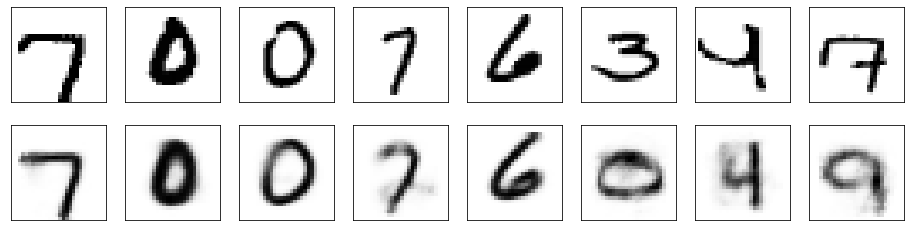

In [7]:
valid_images =  model.test(x_test_flat.to(device), Pe).detach().cpu().numpy()
valid_binary = 0.5*(1 - model.binarizer(model.encoder(x_test_flat.to(device)))).detach().cpu().numpy()   # from bipolar (BPSK) to binary
# show 8 images and their reconstructed versions
plt.figure(figsize=(16,4))
idxs = np.random.randint(x_test.shape[0],size=8)
for k in range(8):
    plt.subplot(2,8,k+1)    
    plt.imshow(np.reshape(x_test_flat[idxs[k]], (image_size,image_size)), interpolation='nearest', cmap='binary')    
    plt.xticks(())
    plt.yticks(())
    
    plt.subplot(2,8,k+1+8)
    plt.imshow(np.reshape(valid_images[idxs[k]], (image_size,image_size)), interpolation='nearest', cmap='binary') 
    plt.xticks(())
    plt.yticks(())

# print binary data of the images
for k in range(8):
    print('Image %d: ' % (k+1), valid_binary[idxs[k],:])

Generate 8 arbitary images just by sampling random bit strings

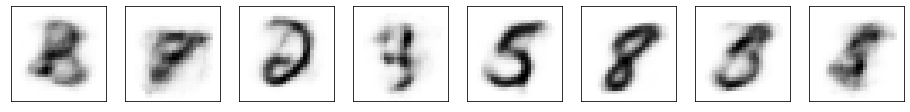

In [8]:
random_data = 1-2*np.random.randint(2,size=(8,bit_per_image))
generated_images = model.decoder(torch.Tensor(random_data).to(device)).detach().cpu().numpy()
plt.figure(figsize=(16,2))
for k in range(8):
    plt.subplot(1,8,k+1)
    plt.imshow(np.reshape(generated_images[k],(image_size,image_size)), interpolation='nearest', cmap='binary')
    plt.xticks(())
    plt.yticks(())